# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [6]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 15.746s 


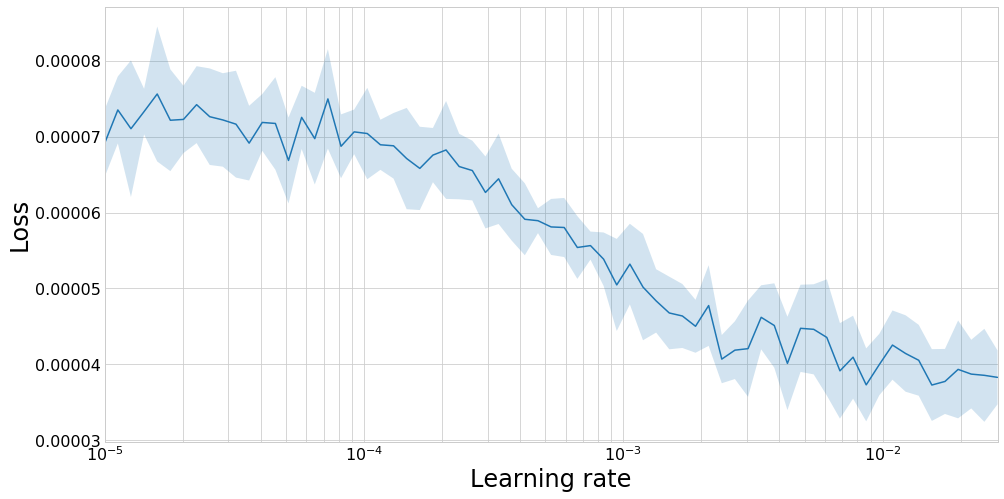

______________________________________



In [5]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'reverse':False, 'cycle_mult':1, 'scale':25, 'redux_decay':False},
                 'SWA':{'renewal':1, 'sgd_replacement':False, 'start':1},}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.242564). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121675). Check your callbacks.
  % delta_t_median)


1 New best found: 3.663810896250652e-05
2 New best found: 3.478551309817704e-05
3 New best found: 3.468899027939187e-05
4 New best found: 3.38847682258347e-05
6 New best found: 3.38497606695455e-05
8 New best found: 3.3270522477687334e-05
10 New best found: 3.3075297699542715e-05
13 New best found: 3.3040584310947455e-05
14 New best found: 3.291263735009125e-05
15 New best found: 3.28793012566166e-05
17 New best found: 3.281860398419667e-05
18 New best found: 3.272119518514955e-05
19 New best found: 3.2602108105493243e-05
21 New best found: 3.256209151004441e-05
24 New best found: 3.2554298438481054e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.2551854343910234e-05, default loss 3.2551854343910234e-05
Saving snapshot 1
25 New best found: 3.2551854343910234e-05
26 swa loss 3.2551854343910234e-05, default loss 3.353192173381103e-05
26 New best found: 3.2551854343910234e-05
27 swa loss 3.2551854343910234e-05, default loss 3.300416824495187e-05
27 New best found: 3.2551854343910234

109 swa loss 3.229691261512926e-05, default loss 3.247343540424481e-05
110 swa loss 3.229691261512926e-05, default loss 3.2812045632454104e-05
111 swa loss 3.229691261512926e-05, default loss 3.256408259621821e-05
112 swa loss 3.229691261512926e-05, default loss 3.262793153189705e-05
113 swa loss 3.229691261512926e-05, default loss 3.282588243673672e-05
114 swa loss 3.229691261512926e-05, default loss 3.245730209600879e-05
115 swa loss 3.229691261512926e-05, default loss 3.2428047734720163e-05
116 swa loss 3.229691261512926e-05, default loss 3.246056690404657e-05
117 swa loss 3.229691261512926e-05, default loss 3.2365432182268704e-05
118 swa loss 3.229691261512926e-05, default loss 3.230617870431161e-05
119 swa loss 3.229691261512926e-05, default loss 3.22942490427522e-05
120 swa loss 3.229691261512926e-05, default loss 3.226251988235162e-05
121 swa loss 3.229691261512926e-05, default loss 3.230984676629305e-05
122 swa loss 3.229691261512926e-05, default loss 3.230455811572028e-05
123 

188 swa loss 3.221837311866693e-05, default loss 3.306144196685636e-05
189 swa loss 3.221837311866693e-05, default loss 3.2583987519319637e-05
190 swa loss 3.221837311866693e-05, default loss 3.264746701024706e-05
191 swa loss 3.221837311866693e-05, default loss 3.283496155927423e-05
192 swa loss 3.221837311866693e-05, default loss 3.263068841188215e-05
193 swa loss 3.221837311866693e-05, default loss 3.280673280969495e-05
194 swa loss 3.221837311866693e-05, default loss 3.276240159830195e-05
195 swa loss 3.221837311866693e-05, default loss 3.2580805181351026e-05
196 swa loss 3.221837311866693e-05, default loss 3.253792460891418e-05
197 swa loss 3.221837311866693e-05, default loss 3.254059983446496e-05
198 swa loss 3.221837311866693e-05, default loss 3.252216482142103e-05
199 swa loss 3.221837311866693e-05, default loss 3.251246318104677e-05
model is 5 epochs old
new model is 2 epochs old
Checking renewal swa model, current model: 3.223453368264018e-05, new model: 3.2347625849070024e-0

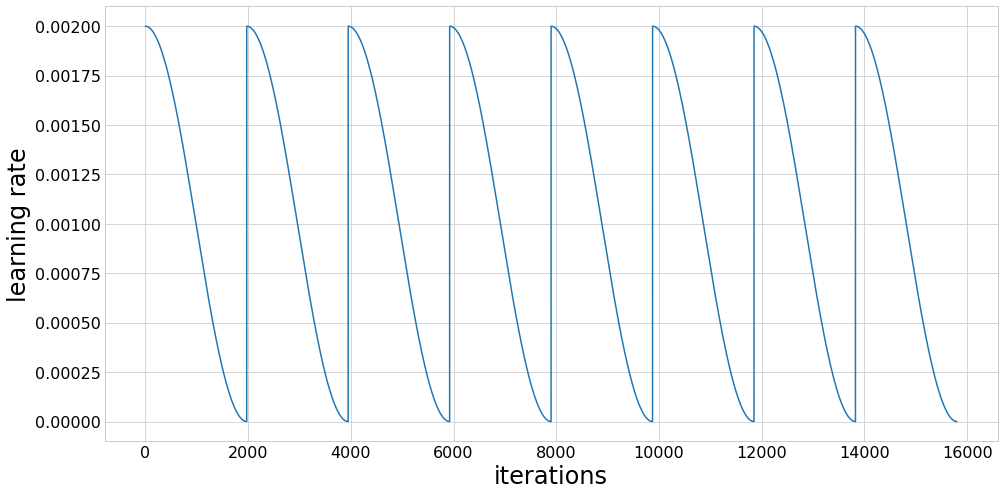

Fold took 245.410s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268363). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134558). Check your callbacks.
  % delta_t_median)


1 New best found: 3.52393525460284e-05
2 New best found: 3.448837252582892e-05
3 New best found: 3.366812435991873e-05
4 New best found: 3.3191210406594926e-05
7 New best found: 3.280143081508009e-05
8 New best found: 3.2749330967126285e-05
9 New best found: 3.2489158150830756e-05
11 New best found: 3.246735547064131e-05
13 New best found: 3.200557047066986e-05
16 New best found: 3.195674383180499e-05
18 New best found: 3.184365873898721e-05
19 New best found: 3.1825049222212584e-05
20 New best found: 3.169434475100441e-05
21 New best found: 3.167813333948502e-05
22 New best found: 3.1667690322922916e-05
23 New best found: 3.165999151543444e-05
24 New best found: 3.164968049028564e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.164610555754578e-05, default loss 3.164610555754578e-05
Saving snapshot 1
25 New best found: 3.164610555754578e-05
26 swa loss 3.164610555754578e-05, default loss 3.320792983352083e-05
26 New best found: 3.164610555754578e-05
27 swa loss 3.164610555754578e

109 swa loss 3.142452627134695e-05, default loss 3.196816172323755e-05
110 swa loss 3.142452627134695e-05, default loss 3.2003399570660066e-05
111 swa loss 3.142452627134695e-05, default loss 3.2017719888958126e-05
112 swa loss 3.142452627134695e-05, default loss 3.1683033843450443e-05
113 swa loss 3.142452627134695e-05, default loss 3.1608885956090954e-05
114 swa loss 3.142452627134695e-05, default loss 3.17711967693287e-05
115 swa loss 3.142452627134695e-05, default loss 3.184008196552211e-05
116 swa loss 3.142452627134695e-05, default loss 3.1658863185557734e-05
117 swa loss 3.142452627134695e-05, default loss 3.160505080641733e-05
118 swa loss 3.142452627134695e-05, default loss 3.15794452434946e-05
119 swa loss 3.142452627134695e-05, default loss 3.152680276406383e-05
120 swa loss 3.142452627134695e-05, default loss 3.1505970873680784e-05
121 swa loss 3.142452627134695e-05, default loss 3.147220473287891e-05
122 swa loss 3.142452627134695e-05, default loss 3.145868927633028e-05
12

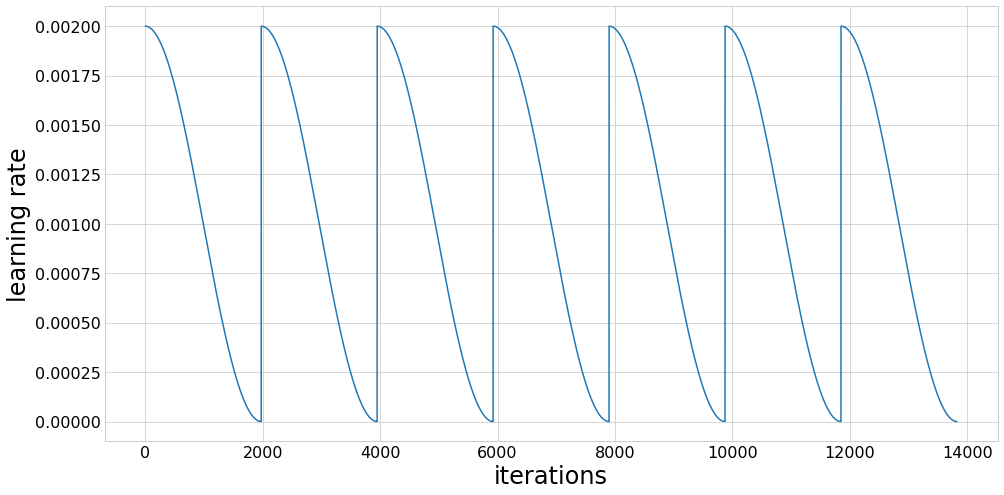

Fold took 218.949s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.266982). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133859). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6761622452468145e-05
2 New best found: 3.3975245920009914e-05
3 New best found: 3.3543577732052655e-05
4 New best found: 3.3373471794766375e-05
6 New best found: 3.3319522760575636e-05
7 New best found: 3.258287678618217e-05
10 New best found: 3.2482854765839873e-05
11 New best found: 3.243713344418211e-05
12 New best found: 3.228357675834559e-05
14 New best found: 3.21462157939095e-05
15 New best found: 3.1960205810901246e-05
19 New best found: 3.191677689756034e-05
20 New best found: 3.186669596470892e-05
22 New best found: 3.180184952507261e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.181824172061169e-05, default loss 3.181824172061169e-05
Saving snapshot 1
26 swa loss 3.181824172061169e-05, default loss 3.289182726875879e-05
27 swa loss 3.181824172061169e-05, default loss 3.3046072824799923e-05
28 swa loss 3.181824172061169e-05, default loss 3.311816873465432e-05
29 swa loss 3.181824172061169e-05, default loss 3.221784883353393e-05
30 swa loss 3.1818241

106 swa loss 3.1629809509468035e-05, default loss 3.25973451777827e-05
106 New best found: 3.1629809509468035e-05
107 swa loss 3.1629809509468035e-05, default loss 3.2433766694157386e-05
107 New best found: 3.1629809509468035e-05
108 swa loss 3.1629809509468035e-05, default loss 3.235652129224036e-05
108 New best found: 3.1629809509468035e-05
109 swa loss 3.1629809509468035e-05, default loss 3.256817529472755e-05
109 New best found: 3.1629809509468035e-05
110 swa loss 3.1629809509468035e-05, default loss 3.198252855218016e-05
110 New best found: 3.1629809509468035e-05
111 swa loss 3.1629809509468035e-05, default loss 3.223183498121216e-05
111 New best found: 3.1629809509468035e-05
112 swa loss 3.1629809509468035e-05, default loss 3.1973114994616484e-05
112 New best found: 3.1629809509468035e-05
113 swa loss 3.1629809509468035e-05, default loss 3.2336922897957265e-05
113 New best found: 3.1629809509468035e-05
114 swa loss 3.1629809509468035e-05, default loss 3.206802699423861e-05
114 Ne

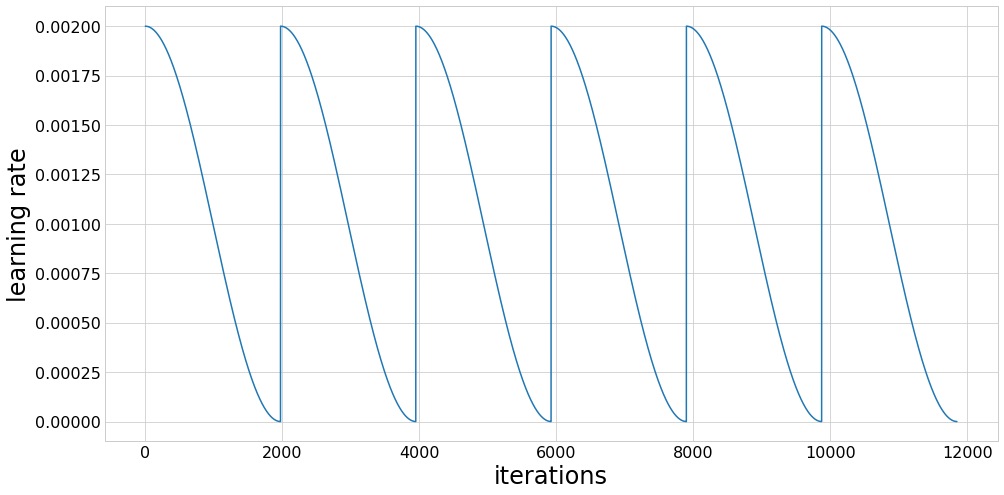

Fold took 193.152s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299360). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.150052). Check your callbacks.
  % delta_t_median)


1 New best found: 3.638016595011698e-05
2 New best found: 3.5500878389420244e-05
3 New best found: 3.497049974553644e-05
4 New best found: 3.436514723757582e-05
5 New best found: 3.372093610711769e-05
6 New best found: 3.3409855871878494e-05
9 New best found: 3.30334997710954e-05
13 New best found: 3.29883744385041e-05
15 New best found: 3.268195365745054e-05
16 New best found: 3.2677733023930576e-05
17 New best found: 3.25881918379243e-05
18 New best found: 3.252549634787254e-05
20 New best found: 3.2481368814328446e-05
21 New best found: 3.2460976989098005e-05
23 New best found: 3.244372568231648e-05
24 New best found: 3.243744054475675e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.243324053997186e-05, default loss 3.243324053997186e-05
Saving snapshot 1
25 New best found: 3.243324053997186e-05
26 swa loss 3.243324053997186e-05, default loss 3.3756901929345486e-05
26 New best found: 3.243324053997186e-05
27 swa loss 3.243324053997186e-05, default loss 3.396510272293119e-05
27

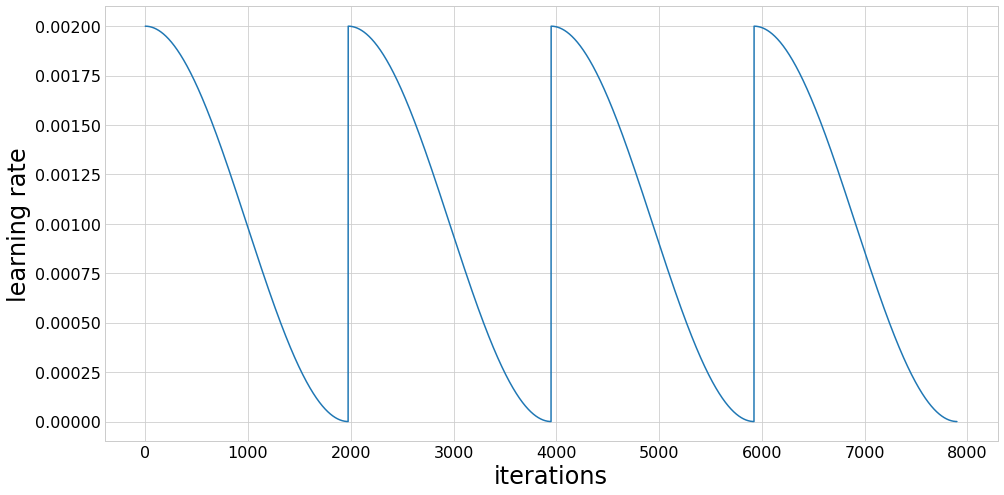

Fold took 129.531s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.339650). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170188). Check your callbacks.
  % delta_t_median)


1 New best found: 3.674109354631452e-05
2 New best found: 3.4445372141780946e-05
4 New best found: 3.370337331065686e-05
6 New best found: 3.3592923679234275e-05
7 New best found: 3.3079292009924914e-05
8 New best found: 3.298645301204696e-05
10 New best found: 3.2865073170710225e-05
11 New best found: 3.269436238331779e-05
12 New best found: 3.263790276694629e-05
14 New best found: 3.261362516059708e-05
15 New best found: 3.252324657659228e-05
16 New best found: 3.2460770724121986e-05
17 New best found: 3.238005206147816e-05
19 New best found: 3.229057318497709e-05
20 New best found: 3.221287461266005e-05
21 New best found: 3.2184663798038037e-05
23 New best found: 3.2179776630008924e-05
24 New best found: 3.216355548935331e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.2161259961835274e-05, default loss 3.2161259961835274e-05
Saving snapshot 1
25 New best found: 3.2161259961835274e-05
26 swa loss 3.2161259961835274e-05, default loss 3.3514037099188696e-05
26 New best found: 3.

107 swa loss 3.198568715356249e-05, default loss 3.243663414234131e-05
107 New best found: 3.198568715356249e-05
108 swa loss 3.198568715356249e-05, default loss 3.249668663706059e-05
108 New best found: 3.198568715356249e-05
109 swa loss 3.198568715356249e-05, default loss 3.248352736664178e-05
109 New best found: 3.198568715356249e-05
110 swa loss 3.198568715356249e-05, default loss 3.271467665378531e-05
110 New best found: 3.198568715356249e-05
111 swa loss 3.198568715356249e-05, default loss 3.2613795000671835e-05
111 New best found: 3.198568715356249e-05
112 swa loss 3.198568715356249e-05, default loss 3.24699887251953e-05
112 New best found: 3.198568715356249e-05
113 swa loss 3.198568715356249e-05, default loss 3.26809732362599e-05
113 New best found: 3.198568715356249e-05
114 swa loss 3.198568715356249e-05, default loss 3.248116961584293e-05
114 New best found: 3.198568715356249e-05
115 swa loss 3.198568715356249e-05, default loss 3.2353701062607794e-05
115 New best found: 3.198

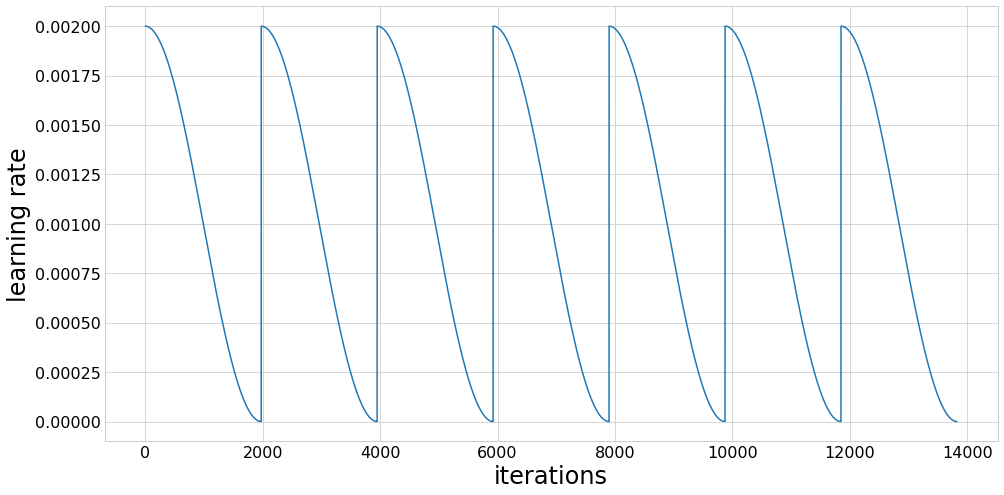

Fold took 241.039s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.379049). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189903). Check your callbacks.
  % delta_t_median)


1 New best found: 3.46478439208339e-05
2 New best found: 3.367834830326289e-05
3 New best found: 3.270603876450772e-05
5 New best found: 3.1788380248317684e-05
6 New best found: 3.1690634184490556e-05
8 New best found: 3.165420833069371e-05
9 New best found: 3.149718721370764e-05
10 New best found: 3.137150309409819e-05
12 New best found: 3.1162637233636556e-05
13 New best found: 3.107964626052689e-05
14 New best found: 3.0902823271996246e-05
17 New best found: 3.082185587098723e-05
18 New best found: 3.069501829793228e-05
20 New best found: 3.061060244893642e-05
21 New best found: 3.0578944540966455e-05
22 New best found: 3.057653284115365e-05
23 New best found: 3.0562122241806965e-05
24 New best found: 3.055888469461228e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.055716946790377e-05, default loss 3.055716946790377e-05
Saving snapshot 1
25 New best found: 3.055716946790377e-05
26 swa loss 3.055716946790377e-05, default loss 3.1523506418804626e-05
26 New best found: 3.0557169

107 swa loss 3.02476296055929e-05, default loss 3.0498150770677788e-05
108 swa loss 3.02476296055929e-05, default loss 3.0836233767070196e-05
109 swa loss 3.02476296055929e-05, default loss 3.0528157199125756e-05
110 swa loss 3.02476296055929e-05, default loss 3.062050299464451e-05
111 swa loss 3.02476296055929e-05, default loss 3.067025722727501e-05
112 swa loss 3.02476296055929e-05, default loss 3.068059895413276e-05
113 swa loss 3.02476296055929e-05, default loss 3.0447294618731086e-05
114 swa loss 3.02476296055929e-05, default loss 3.0487923094992708e-05
115 swa loss 3.02476296055929e-05, default loss 3.035688859878676e-05
116 swa loss 3.02476296055929e-05, default loss 3.0411840284193176e-05
117 swa loss 3.02476296055929e-05, default loss 3.0332617393065624e-05
118 swa loss 3.02476296055929e-05, default loss 3.0399041921908854e-05
119 swa loss 3.02476296055929e-05, default loss 3.0288674450931077e-05
120 swa loss 3.02476296055929e-05, default loss 3.026932384682673e-05
121 swa los

185 swa loss 3.016821925567818e-05, default loss 3.061473185331593e-05
186 swa loss 3.016821925567818e-05, default loss 3.083474544227456e-05
187 swa loss 3.016821925567818e-05, default loss 3.0872740406597976e-05
188 swa loss 3.016821925567818e-05, default loss 3.073021985105859e-05
189 swa loss 3.016821925567818e-05, default loss 3.0843286623754004e-05
190 swa loss 3.016821925567818e-05, default loss 3.097679144756688e-05
191 swa loss 3.016821925567818e-05, default loss 3.091111059378653e-05
192 swa loss 3.016821925567818e-05, default loss 3.066335392700479e-05
193 swa loss 3.016821925567818e-05, default loss 3.05823523025859e-05
194 swa loss 3.016821925567818e-05, default loss 3.047106899880582e-05
195 swa loss 3.016821925567818e-05, default loss 3.0515821700757944e-05
196 swa loss 3.016821925567818e-05, default loss 3.053579356853486e-05
197 swa loss 3.016821925567818e-05, default loss 3.0482807627189433e-05
198 swa loss 3.016821925567818e-05, default loss 3.0484944996110953e-05
19

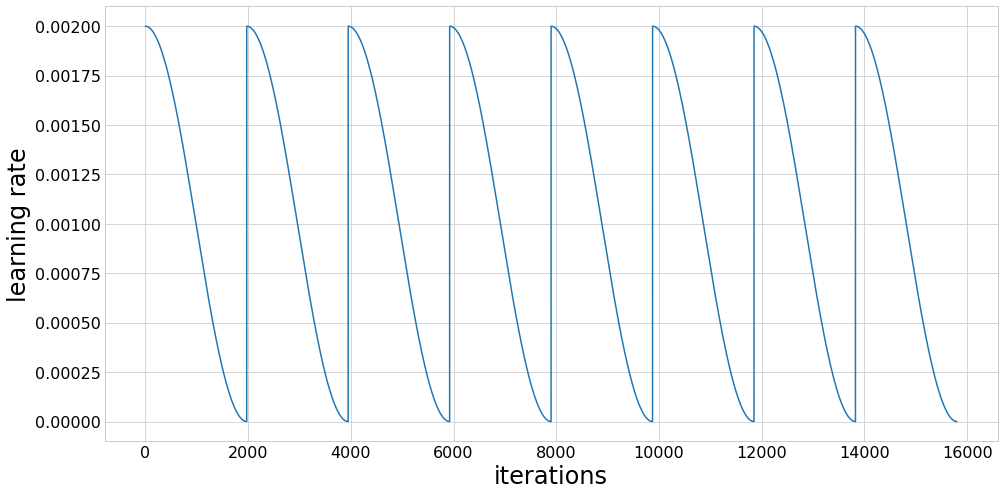

Fold took 281.846s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.399237). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199997). Check your callbacks.
  % delta_t_median)


1 New best found: 3.6590854225803856e-05
2 New best found: 3.528834766577422e-05
3 New best found: 3.479322761216611e-05
4 New best found: 3.3899822456216035e-05
5 New best found: 3.381809513153592e-05
6 New best found: 3.353778851103753e-05
8 New best found: 3.345043998698566e-05
9 New best found: 3.330773819600648e-05
10 New best found: 3.3244912416341044e-05
11 New best found: 3.2897931099533995e-05
12 New best found: 3.276988966509963e-05
16 New best found: 3.273064144701241e-05
17 New best found: 3.265092396013407e-05
18 New best found: 3.246989726912488e-05
19 New best found: 3.246417630335456e-05
21 New best found: 3.2368553746972835e-05
22 New best found: 3.235849494822319e-05
23 New best found: 3.235370315288409e-05
24 New best found: 3.2346293351535885e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.234635339817135e-05, default loss 3.234635339817135e-05
Saving snapshot 1
26 swa loss 3.234635339817135e-05, default loss 3.348911653053941e-05
27 swa loss 3.234635339817135

120 swa loss 3.212475952021205e-05, default loss 3.2208189981661486e-05
121 swa loss 3.212475952021205e-05, default loss 3.231221777718178e-05
122 swa loss 3.212475952021205e-05, default loss 3.224580760866444e-05
123 swa loss 3.212475952021205e-05, default loss 3.225790121952157e-05
124 swa loss 3.212475952021205e-05, default loss 3.2258438600122884e-05
model is 4 epochs old
new model is 2 epochs old
Checking renewal swa model, current model: 3.2118945493878414e-05, new model: 3.2132647419474825e-05
Current model better, renewing
____________________


125 swa loss 3.2118945493878414e-05, default loss 3.225832868626034e-05
Saving snapshot 5
125 New best found: 3.2118945493878414e-05
126 swa loss 3.2118945493878414e-05, default loss 3.3544908366423485e-05
126 New best found: 3.2118945493878414e-05
127 swa loss 3.2118945493878414e-05, default loss 3.3389354485689136e-05
127 New best found: 3.2118945493878414e-05
128 swa loss 3.2118945493878414e-05, default loss 3.29926111250387e-05
128 

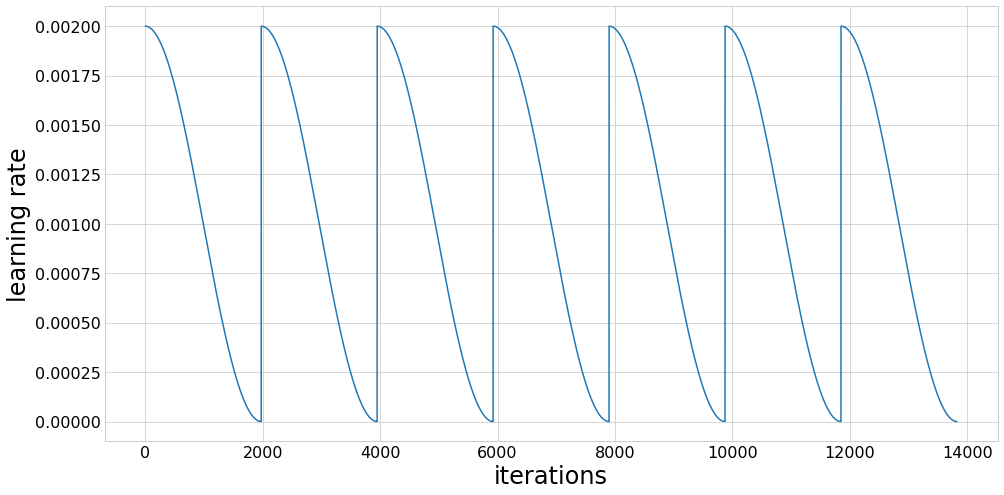

Fold took 252.377s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.432733). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216761). Check your callbacks.
  % delta_t_median)


1 New best found: 3.648823015452453e-05
2 New best found: 3.500381769320348e-05
4 New best found: 3.3947998619952266e-05
5 New best found: 3.382283735640875e-05
7 New best found: 3.3766902997307606e-05
8 New best found: 3.341667064405259e-05
9 New best found: 3.341396328419983e-05
10 New best found: 3.313338423191592e-05
12 New best found: 3.3102090163130836e-05
13 New best found: 3.2966755134139025e-05
14 New best found: 3.269817904602261e-05
15 New best found: 3.266897697758642e-05
18 New best found: 3.257704725530202e-05
19 New best found: 3.2524302344909914e-05
20 New best found: 3.2522252130292086e-05
21 New best found: 3.2454412132097416e-05
24 New best found: 3.2430674173308494e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.242652888473263e-05, default loss 3.242652888473263e-05
Saving snapshot 1
25 New best found: 3.242652888473263e-05
26 swa loss 3.242652888473263e-05, default loss 3.3900186593170606e-05
26 New best found: 3.242652888473263e-05
27 swa loss 3.24265288847

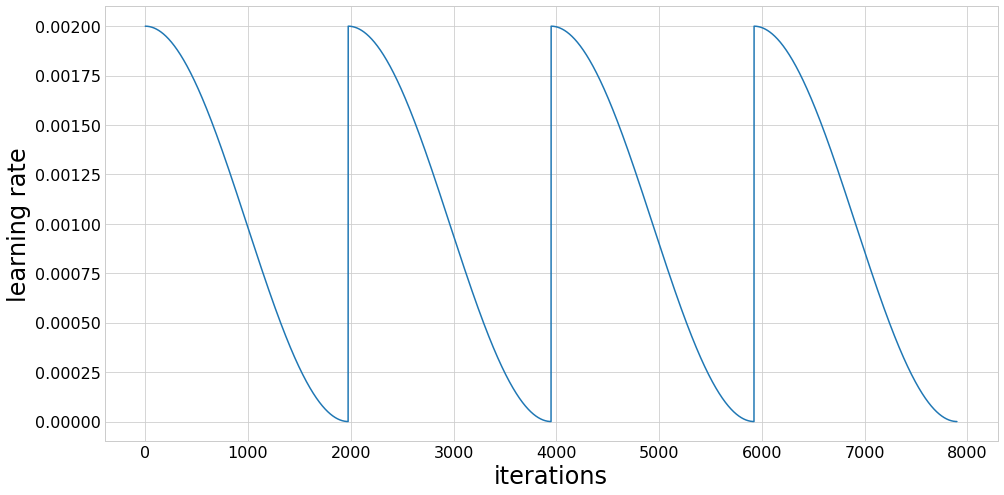

Fold took 145.498s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.473413). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237096). Check your callbacks.
  % delta_t_median)


1 New best found: 3.598517648351844e-05
2 New best found: 3.439483185939025e-05
3 New best found: 3.314638505107723e-05
4 New best found: 3.303649177250918e-05
5 New best found: 3.2839318092737814e-05
7 New best found: 3.2445216801716017e-05
8 New best found: 3.2360934215103045e-05
9 New best found: 3.213792302121874e-05
11 New best found: 3.201633802527795e-05
12 New best found: 3.197909651280497e-05
13 New best found: 3.192961082822876e-05
14 New best found: 3.177296009162092e-05
16 New best found: 3.170354938774835e-05
17 New best found: 3.1575486735528105e-05
19 New best found: 3.1546586815966295e-05
20 New best found: 3.1503088616591414e-05
21 New best found: 3.1471626456914234e-05
22 New best found: 3.145922867770423e-05
23 New best found: 3.141853833585628e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.141894969667191e-05, default loss 3.141894969667191e-05
Saving snapshot 1
26 swa loss 3.141894969667191e-05, default loss 3.2777021609945226e-05
27 swa loss 3.1418949696671

120 swa loss 3.12606466919533e-05, default loss 3.14846841560211e-05
121 swa loss 3.12606466919533e-05, default loss 3.1439309919369405e-05
122 swa loss 3.12606466919533e-05, default loss 3.141646427320666e-05
123 swa loss 3.12606466919533e-05, default loss 3.143572109111119e-05
124 swa loss 3.12606466919533e-05, default loss 3.1428858618892265e-05
model is 4 epochs old
new model is 2 epochs old
Checking renewal swa model, current model: 3.126484207168687e-05, new model: 3.130364981116145e-05
Current model better, renewing
____________________


125 swa loss 3.126484207168687e-05, default loss 3.142746587982401e-05
Saving snapshot 5
Early stopping after 125 epochs
Score is: {'loss': 3.1254988846194465e-05, 'wAUC': 0.06180062251182372, 'AUC': 0.09859576997088726, 'AMS': 3.906394198213664, 'cut': 0.9480796456336975}


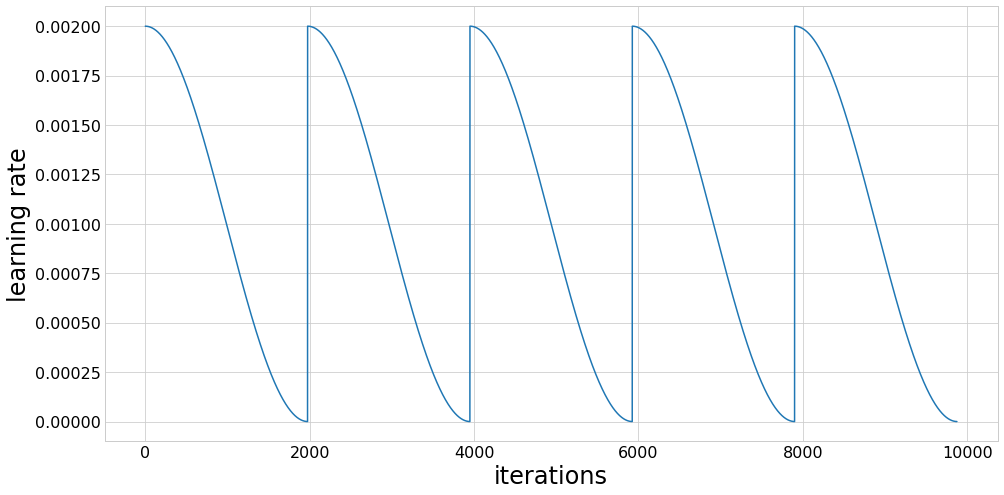

Fold took 189.776s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.494104). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247467). Check your callbacks.
  % delta_t_median)


1 New best found: 3.730221607984276e-05
2 New best found: 3.425404690497089e-05
4 New best found: 3.379177241295111e-05
5 New best found: 3.3248922422353646e-05
7 New best found: 3.3172787950024943e-05
9 New best found: 3.2988505010143855e-05
11 New best found: 3.2632237231882754e-05
12 New best found: 3.2555069177760745e-05
16 New best found: 3.248019130696775e-05
17 New best found: 3.2270887614868115e-05
18 New best found: 3.226150384143694e-05
20 New best found: 3.22155041321821e-05
21 New best found: 3.2200084518990476e-05
23 New best found: 3.21869345541927e-05
SWA beginning
model is 0 epochs old
25 swa loss 3.2188864490308336e-05, default loss 3.2188864490308336e-05
Saving snapshot 1
26 swa loss 3.2188864490308336e-05, default loss 3.314921036217129e-05
27 swa loss 3.2188864490308336e-05, default loss 3.291047048405744e-05
28 swa loss 3.2188864490308336e-05, default loss 3.325075958127855e-05
29 swa loss 3.2188864490308336e-05, default loss 3.297104486991884e-05
30 swa loss 3.218

121 swa loss 3.190678812825354e-05, default loss 3.198166914371541e-05
122 swa loss 3.190678812825354e-05, default loss 3.189675147368689e-05
123 swa loss 3.190678812825354e-05, default loss 3.1903687078738586e-05
124 swa loss 3.190678812825354e-05, default loss 3.1891197290678975e-05
model is 4 epochs old
new model is 2 epochs old
Checking renewal swa model, current model: 3.187981677983771e-05, new model: 3.183616720343707e-05
New model better, replacing
____________________


125 swa loss 3.183616720343707e-05, default loss 3.1888588693982454e-05
Saving snapshot 5
125 New best found: 3.183616720343707e-05
126 swa loss 3.183616720343707e-05, default loss 3.255180869309697e-05
126 New best found: 3.183616720343707e-05
127 swa loss 3.183616720343707e-05, default loss 3.274418413639069e-05
127 New best found: 3.183616720343707e-05
128 swa loss 3.183616720343707e-05, default loss 3.246786872041412e-05
128 New best found: 3.183616720343707e-05
129 swa loss 3.183616720343707e-05, default l

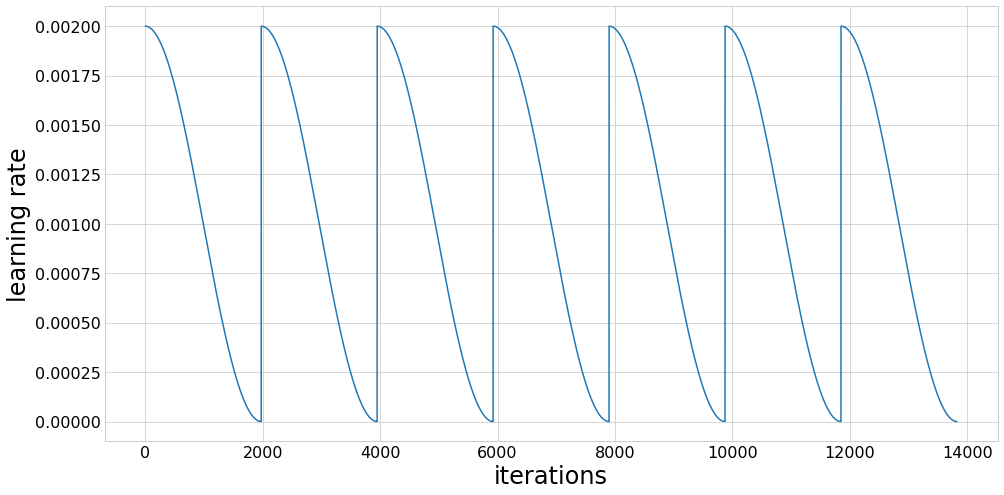

Fold took 276.619s


______________________________________
Training finished
Cross-validation took 2174.375s 


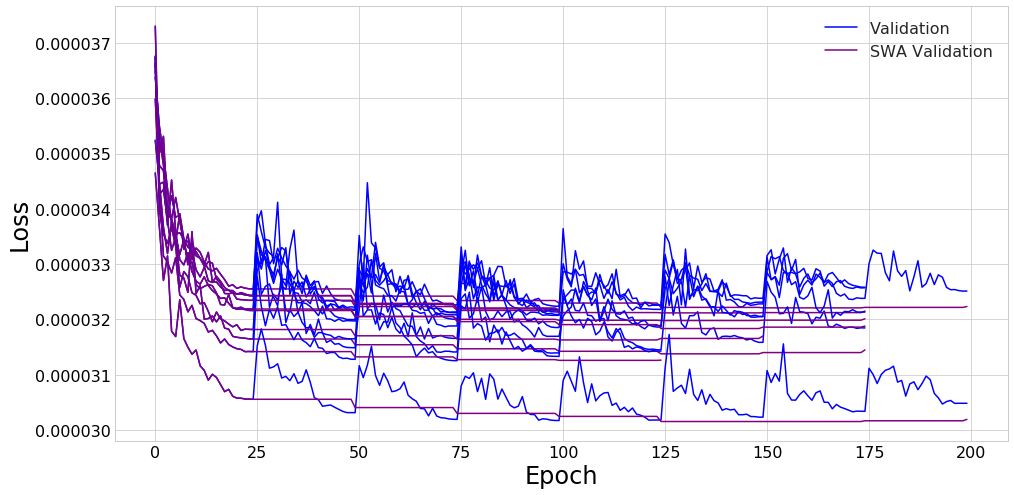

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.0629 +- 0.0007
Mean AUC = 0.0975 +- 0.0005
Mean AMS = 3.95 +- 0.06
Mean cut = 0.965 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [8]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [9]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [10]:
%%capture --no-stdout
ensemble, weights = assemble_ensemble(results, ensemble_size, metric=ensemble_mode)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.015471560568702e-05
Model 1 is 8 with loss = 3.1254988846194465e-05
Model 2 is 1 with loss = 3.137882626873086e-05
Model 3 is 2 with loss = 3.1629809509468035e-05
Model 4 is 9 with loss = 3.183616720343707e-05
Model 5 is 4 with loss = 3.198043250037678e-05
Model 6 is 3 with loss = 3.208069543350831e-05
Model 7 is 6 with loss = 3.2118945493878414e-05
Model 8 is 7 with loss = 3.213029530785638e-05
Model 9 is 0 with loss = 3.220960753096733e-05


## Response on validation data without TTA

In [11]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [12]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.001411559645831585s per sample

Predicting fold 2 out of 10
Prediction took 0.0003079506650567055s per sample

Predicting fold 3 out of 10
Prediction took 0.0003078635431826115s per sample

Predicting fold 4 out of 10
Prediction took 0.0003064278431236744s per sample

Predicting fold 5 out of 10
Prediction took 0.00031171259954571723s per sample

Predicting fold 6 out of 10
Prediction took 0.0003076601874083281s per sample

Predicting fold 7 out of 10
Prediction took 0.0003076337117701769s per sample

Predicting fold 8 out of 10
Prediction took 0.0003064656741917133s per sample

Predicting fold 9 out of 10
Prediction took 0.0003108138684183359s per sample

Predicting fold 10 out of 10
Prediction took 0.0003041908614337444s per sample



In [13]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [14]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.90433059624662, weighted 0.9361638951601887


Best cut at 0.9633837872081332 corresponds to AMS of 3.8341938368420045
Maximum AMS for data is 3.956156728602477 at cut of 0.9658243656158447
CPU times: user 25.4 s, sys: 0 ns, total: 25.4 s
Wall time: 25.4 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


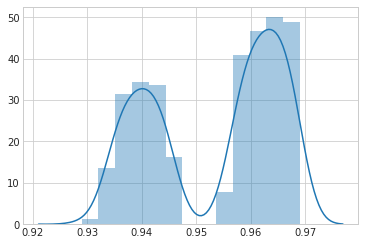

In [15]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9535457 corresponds to AMS of 3.736811785664622
Maximum AMS for data is 3.956156728602477 at cut of 0.9658243656158447
CPU times: user 97.8 ms, sys: 81.3 ms, total: 179 ms
Wall time: 80.4 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


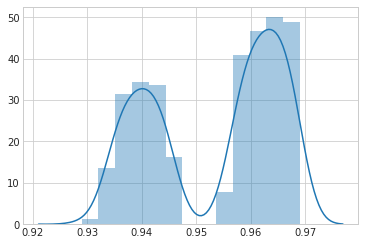

In [16]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [17]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [18]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003075608675452796s per sample

Predicting fold 2 out of 10
Prediction took 0.0003098186421123418s per sample

Predicting fold 3 out of 10
Prediction took 0.00030812266641719777s per sample

Predicting fold 4 out of 10
Prediction took 0.00031072948304089633s per sample

Predicting fold 5 out of 10
Prediction took 0.000307823139869354s per sample

Predicting fold 6 out of 10
Prediction took 0.0003100135610523549s per sample

Predicting fold 7 out of 10
Prediction took 0.0003061091939834031s per sample

Predicting fold 8 out of 10
Prediction took 0.00030753173503008757s per sample

Predicting fold 9 out of 10
Prediction took 0.00030280519209124825s per sample

Predicting fold 10 out of 10
Prediction took 0.00030327182181856847s per sample

CPU times: user 3min 4s, sys: 10.1 s, total: 3min 14s
Wall time: 2min 49s


In [19]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.5954078448227635 : 3.731421594041388


(3.5954078448227635, 3.731421594041388)

In [20]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.74594294742368 : 3.7634017594625413


(3.74594294742368, 3.7634017594625413)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)